In [1]:
import numpy as np
import scipy.constants
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import math
import h5py
import os
import CDO

from DREAM.DREAMOutput import DREAMOutput
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.animation import FuncAnimation
from IPython import display
#%matplotlib ipympl

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.constrained_layout.use'] = True

def animateRE(data, at_radial_cell, at_timestep=0, to_timestep=-1, 
              from_momentum_cell=0, to_momentum_cell=-1):
    data_to_plot = data.re_distribution_t_r_xi_p[0][at_timestep, at_radial_cell, :, 
                                                    from_momentum_cell:to_momentum_cell]
    if data_to_plot.max() < 1e-1:
        vmax = 1 
        vmin = 1e-1
    elif data_to_plot.min() < 1e-1:
        vmin = 1e-1
        vmax = data_to_plot.max()
    else:
        vmin = data_to_plot.min()
        vmax = data_to_plot.max()

    plt.clf()
    plotted = [plt.pcolormesh(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], 
                              data.re_pitchgrid_degrees, data_to_plot, 
                              norm=colors.LogNorm(vmin=vmin, vmax=vmax))]

    def reAnimationFunction(frame):
        frame = frame + at_timestep  # frame + index of starting timestep
        data_to_plot = data.re_distribution_t_r_xi_p[0][frame, at_radial_cell, :, 
                                                        from_momentum_cell:to_momentum_cell]
        if data_to_plot.min() < 1e-1:
            vmin = 1e-1
        else:
            vmin = data_to_plot.min()

        plt.clf()
        plotted[0] = plt.pcolormesh(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], 
                                    data.re_pitchgrid_degrees, data_to_plot, 
                                    norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
        axes = plt.gca()
        axes.set_facecolor('black')
        #axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
        axes.set_axisbelow(False)
        #axes.yaxis.grid(True, which='major', linestyle="--")
        axes.tick_params(axis='y', which='major', bottom=False)
        axes.set_xlim(data.re_momentumgrid[from_momentum_cell], 
                      data.re_momentumgrid[to_momentum_cell - 1])
        fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
        plt.title("Energy and pitch distribution of electrons\nt=" 
                  + '{0:.3f}'.format(np.round(data.timegrid_ms[frame] + t0, 3))
                  + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
        plt.ylabel(r"Pitch angle [degrees]")
        plt.xlabel(r"Momentum normalized to $m_ec$ [-]")
    

    figsize=[10, 5]
    fig = plt.figure(figsize=figsize)

    # Here the frames=... will give the length of the animation in number of timesteps
    if to_timestep < 0:
        temp = len(data.timegrid) + to_timestep + 1
        to_timestep = temp
        
    frames = to_timestep - at_timestep
        
    anim_created = FuncAnimation(fig, reAnimationFunction, frames=frames, 
                                 interval=500, repeat_delay=None)
    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
    
def animateMultiple(dataarrays, start, end, at_radial_cell, 
                    from_momentum_cell=0, to_momentum_cell=-1):
    data = dataarrays[start]
    data_to_plot = data.re_distribution_t_r_xi_p[0][0, at_radial_cell, :, 
                                                    from_momentum_cell:to_momentum_cell]
    if data_to_plot.max() < 1e-1:
        vmax = 1 
        vmin = 1e-1
    elif data_to_plot.min() < 1e-1:
        vmin = 1e-1
        vmax = data_to_plot.max()
    else:
        vmin = data_to_plot.min()
        vmax = data_to_plot.max()

    plt.clf()
    plotted = [plt.pcolormesh(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], 
                              data.re_pitchgrid_degrees, data_to_plot, 
                              norm=colors.LogNorm(vmin=vmin, vmax=vmax))]

    index = start
    subtract = 0
    
    def reAnimationFunction(frame, index):
        if (10 * frame) > (len(dataarrays[index].timegrid_ms) - 1):
            subtract += len(dataarrays[index].timegrid_ms)
            index += 1
            
        data = dataarrays[index]
        frame = 10 * frame - subtract
        data_to_plot = data.re_distribution_t_r_xi_p[0][frame, at_radial_cell, :, 
                                                        from_momentum_cell:to_momentum_cell]
        if data_to_plot.min() < 1e-1:
            vmin = 1e-1
        else:
            vmin = data_to_plot.min()

        plt.clf()
        plotted[0] = plt.pcolormesh(data.re_momentumgrid[from_momentum_cell:to_momentum_cell], 
                                    data.re_pitchgrid_degrees, data_to_plot, 
                                    norm=colors.LogNorm(vmin=vmin, vmax=data_to_plot.max()))
        axes = plt.gca()
        axes.set_facecolor('black')
        #axes.set_yticks(data.re_pitchgrid_degrees_edges, minor=False)
        axes.set_axisbelow(False)
        #axes.yaxis.grid(True, which='major', linestyle="--")
        axes.tick_params(axis='y', which='major', bottom=False)
        axes.set_xlim(data.re_momentumgrid[from_momentum_cell], 
                      data.re_momentumgrid[to_momentum_cell - 1])
        fig.colorbar(plotted[0], ax=axes, label=r"Electron distribution [1/m$^3$]")
        plt.title("Energy and pitch distribution of electrons\nt=" 
                  + '{0:.3f}'.format(np.round(data.timegrid_ms[frame] + t0, 3))
                  + "ms r=" + str(np.round(data.radialgrid[at_radial_cell], 3)) + "m")
        plt.ylabel(r"Pitch angle [degrees]")
        plt.xlabel(r"Momentum normalized to $m_ec$ [-]")
    

    figsize=[10, 5]
    fig = plt.figure(figsize=figsize)
        
    frames = 0
    for data in dataarrays[start:end]:
        frames += len(data.timegrid_ms)
        
    anim_created = FuncAnimation(fig, reAnimationFunction, frames=frames, 
                                 interval=500, repeat_delay=None, fargs=)
    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [2]:
# Opening files
#folder = "../Data/biuniform3/"
folder = "C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Code/ndc2/"
plotfoldername = folder + "plots/"

cdos = []
dos = []
numoffiles = 15

t0 = 0
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    cdos.append(CDO.CustomDREAMOutput(fname, t0))
    t0 = cdos[i-1].timegrid[-1]
    dos.append(DREAMOutput(fname))

print(cdos[-1])
cdos[-1].info()

CustomDREAMOutput object from the file: C:/Users/lefer/Documents/Egyetem/RE Projekt/Current/Code/ndc2/output_15_.h5
.info() - basic information about this file
.list_atrs() - list all attributes of the object
Use help(*object_name*) for further help on the class
Simulation time from 65.1201 ms to 75.1201 ms
Number of saved timesteps: 400
Save timestep (dt): 0.025 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Runawaygrid enabled: True


Simulation time from 65.1201 ms to 75.1201 ms
Number of saved timesteps: 400
Save timestep (dt): 0.025 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Runawaygrid enabled: True


UnboundLocalError: cannot access local variable 'index' where it is not associated with a value

Error in callback <function _draw_all_if_interactive at 0x0000023C47CBBBA0> (for post_execute):


UnboundLocalError: cannot access local variable 'index' where it is not associated with a value

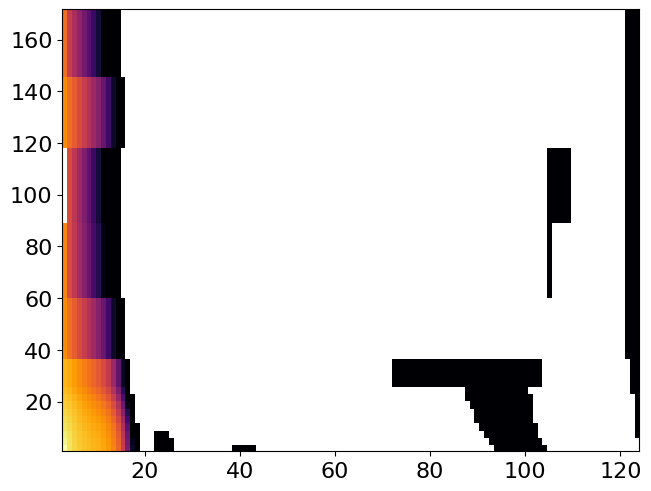

<Figure size 1000x500 with 0 Axes>

In [5]:
data = cdos[-1]
data.info()
at_radial_cell = -2
from_momentum_cell = 0
to_momentum_cell = -1
start = 8
end = 9

animateMultiple(cdos, start, end, at_radial_cell, 
                from_momentum_cell, to_momentum_cell)

Simulation time from 0.1201 ms to 5.1201 ms
Number of saved timesteps: 200
Save timestep (dt): 0.025 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Runawaygrid enabled: True


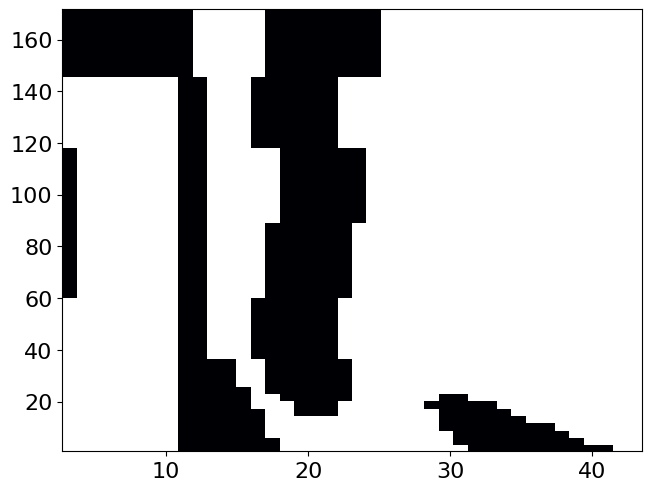

In [6]:
data = cdos[-1]
data.info()
at_radial_cell = -2
at_timestep = 100
to_timestep = -1
from_momentum_cell = 0
to_momentum_cell = 40

animateRE(data, at_radial_cell, at_timestep, to_timestep, from_momentum_cell, to_momentum_cell)

Simulation time from 0.1201 ms to 5.1201 ms
Number of saved timesteps: 200
Save timestep (dt): 0.025 ms
Minor radius: [2.93] m
Number of radial grid cells: 20
Radial step (dr): 0.14650000000000002 m
Hottailgrid enabled: True
Runawaygrid enabled: True


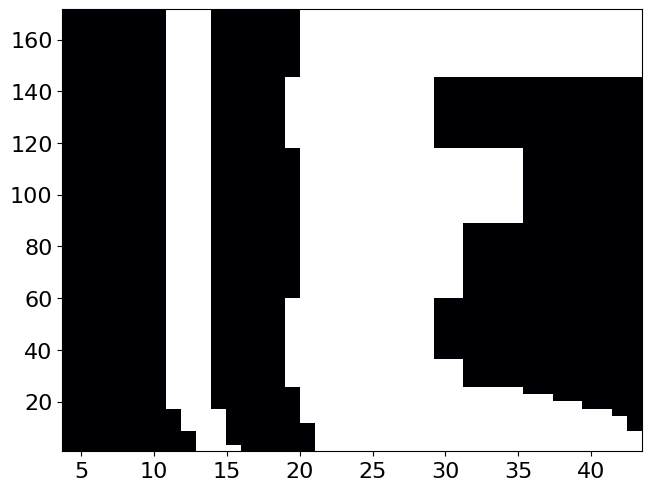

In [8]:
data = cdos[-1]
data.info()
at_radial_cell = -3
at_timestep = 100
to_timestep = -1
from_momentum_cell = 1
to_momentum_cell = 40

animateRE(data, at_radial_cell, at_timestep, to_timestep, from_momentum_cell, to_momentum_cell)

In [ ]:
data = cdos[-1]
data.info()
at_radial_cell = 3
at_timestep = 0
to_timestep = -1
from_momentum_cell = 0
to_momentum_cell = 50

animateRE(data, at_radial_cell, at_timestep, to_timestep, from_momentum_cell, to_momentum_cell)

In [11]:
m0 = 9.1e-31
q = 1.602e-19
c = 3e8
E = 100
t = np.linspace(0, 0.00003, 1000)
K = ((m0 * c**2) / (1 - ((c * np.arcsinh(np.sqrt((q**2 * E**2) / m0**2) * t)**2) / (c**2)))) - (m0 * c**2)
K2 = (m0 * c**2) * ( (1 / np.sqrt(1 - np.sin( (q * E * t) / (m0 * c) )**2 ) ) - 1 )
K_eV = K2 / q

(0.0, 20000000.0)

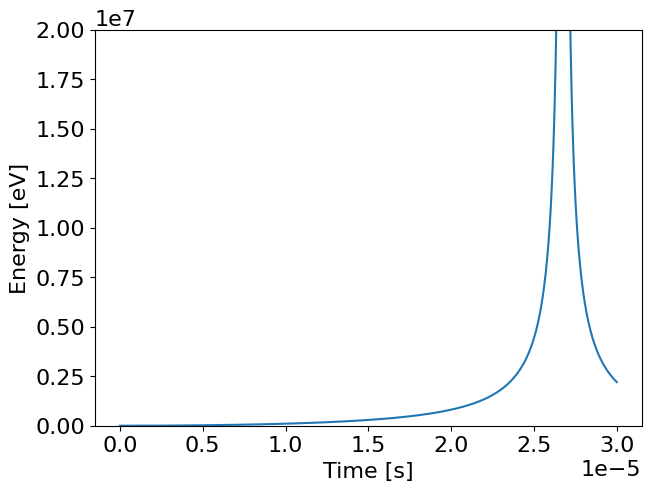

In [12]:
%matplotlib inline
plt1 = plt.plot(t, K_eV)
ax = plt.gca()
ax.set_ylabel("Energy [eV]")
ax.set_xlabel("Time [s]")
ax.set_ylim(0, 2e7)